Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import SwitchingCoordination as sc
import numpy as np
from tqdm import tqdm

from importlib import reload
reload(sc)
# %load_ext autoreload
# %autoreload 2

Define the parameters 

In [6]:
# simulation parameters
#N = 3
ref_time = 1.3
noise_std = 0.5
avg_frequency = 0.0
write_file = False # True
#switching_rate = 0.1

N_min = 3
N_max = 8

# monte-carlo parameters
n_mc_reps = 30

# Define the array of the scanning parameter
switching_rate_arr = np.logspace(-3.0, 2.0, 20)
coupling_strength_arr = np.arange(start = 0.25, stop = 5.0, step = 0.01)
N_arr = np.arange(start = N_min, stop = N_max, step = 1)

Running the parameter scanning

In [7]:
# make an empty out_data to fill in later
out_data = {}
out_data_list = []

for N_i, N in enumerate(tqdm(N_arr)):

    # monte-carlo loop
    for i_switching_rate, switching_rate in enumerate(switching_rate_arr):

        # initialize a parameter dictionary
        params = sc.InitParams(N=N, switchingRate=switching_rate,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file)
        
        # repeat single simulation for "n_mc_reps" times
        for mc_iter in np.arange(n_mc_reps):
            
            #perform a single simulation
            out_data_tmp = sc.SingleSimulation(params)
            out_data[N_i, i_switching_rate, mc_iter] = out_data_tmp

            # make an empty (temporary) dict to put all the data (params + output) into
            tmp_dict = {}
            # put the params into the dict
            for key, val in dict.items(params):
                tmp_dict[key] = val
            # put the time and order arrays into the dict
            tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
            tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
            tmp_dict["mc_iter"] = mc_iter

            # append it to the list 
            out_data_list.append(tmp_dict)

# convert it to a pd.df
out_data_df = pd.DataFrame(out_data_list)

# create a string for the file name
file_name = f'paramscan_order-N{N_arr[0]}-{N_arr[-1]}_sw-rate{switching_rate_arr[0]}-{switching_rate_arr[-1]}'

# save the df to a csv file
out_data_df.to_csv(f'results/{file_name}.csv', index=False)

100%|██████████| 31/31 [00:07<00:00,  4.00it/s]


Plot a single run data

In [12]:
switching_rate_index_to_plot = 0
mc_iter_to_plot = 0
N_index_to_plot = 0

out_data_to_plot = out_data[N_index_to_plot, switching_rate_index_to_plot, mc_iter_to_plot]

# plot single trajectories versus time
plt.figure(figsize=(10,4))
plt.plot(out_data_to_plot[0]['t'],(out_data_to_plot[0]['phi']),'.-')
plt.xlabel('time')
plt.ylabel('phase')
#plot order parameter versus time
plt.figure(figsize=(10,4))
ax=plt.subplot()
plt.plot(out_data_to_plot[0]['t'],out_data_to_plot[0]['order'])
plt.xlabel('time')
plt.ylabel('order parameter')
avg_order=np.mean(out_data_to_plot[0]['order'][-25:])
plt.text(0.2,0.1,'avg order = %.3f' % avg_order,transform=ax.transAxes)

TypeError: tuple indices must be integers or slices, not str

<Figure size 1000x400 with 0 Axes>

Calculate the average order of the monte-carlo simulations

In [87]:
avg_order = np.empty(shape=(len(N_arr),len(switching_rate_arr),n_mc_reps))
for N_i, N in enumerate(N_arr):
    for i_switching_rate, switching_rate in enumerate(switching_rate_arr):
        for mc_iter in np.arange(n_mc_reps):
            out_data_temp = out_data[N_i, i_switching_rate, mc_iter]
            avg_order_tmp = np.mean(out_data_temp[0]['order'])
            avg_order[N_i, i_switching_rate, mc_iter] = avg_order_tmp

# calculate the mean of the average order over monte-carlo reps.
avg_order_over_reps = np.mean(avg_order, axis=2)


Plot the average vs scanning parameter for all N

Text(0, 0.5, 'average order')

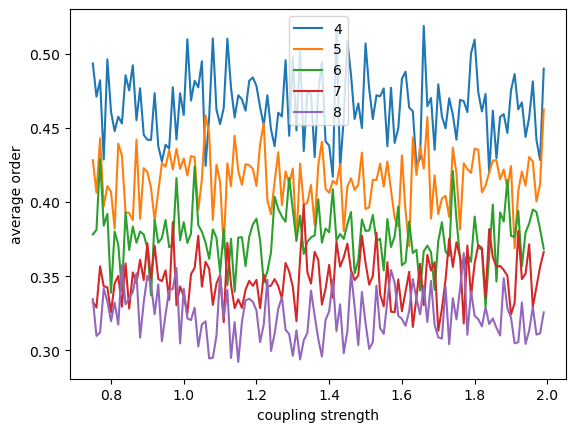

In [88]:
for N_i, N in enumerate(N_arr):
    plt.semilogx(switching_rate_arr, avg_order_over_reps[N_i], label=N)
plt.axvline(x=(1/ref_time), linestyle=':', label=(f'{ref_time}'+'$^{-1}$'))
plt.legend()
plt.xlabel('switching rate')
plt.ylabel("average order")
plt.title(f'Scan of the switching rate varying N (refTime = {ref_time})')
plt.savefig(f'results/{file_name}.png', bbox_inches='tight')